# Gradient Calculation

Determining the gradient of an arbitrary loss function, e.g., RMS spot size or Strehl ratio, with respect to lens parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import optiland.backend as be
from optiland.samples.objectives import ReverseTelephoto
from optiland.analysis import SpotDiagram
from optiland.psf import FFTPSF

In [2]:
be.set_backend("torch")  # all calculations will be done using torch
be.set_precision("float32")  # or "float64" for double precision
be.grad_mode.enable()  # enable gradient calculation. Can also be set to "disable" to save memory if gradients are not needed.
be.set_device("cuda")  # run on GPU if available, otherwise use "cpu" option

In [3]:
lens = ReverseTelephoto()

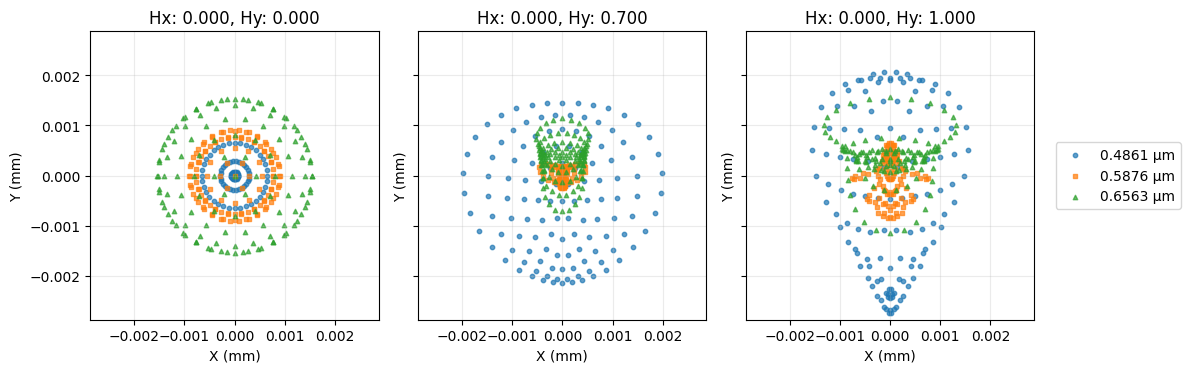

In [4]:
spot = SpotDiagram(lens)
spot.view()

In [5]:
# Record the lens radii of curvature as parameters
radius_params = []
surf_idx = []
for idx, surf in enumerate(lens.surface_group.surfaces):
    if not be.isinf(surf.geometry.radius):  # only add non-infinite radii
        # Create a new tensor for the radius with gradient tracking enabled
        r = (
            surf.geometry.radius.clone()
            .detach()
            .requires_grad_(True)
            .to(be.get_device())
        )
        surf.geometry.radius = r
        radius_params.append(r)
        surf_idx.append(idx)

We decide to build a dual loss function consisting of:

1. The RMS spot spot size at (Hx, Hy) = (0, 1) field and 0.5876 µm.
2. The Strehl ratio for the on-axis field.

Any combinatation of analyses or calculations can be included in the loss function.

In [7]:
# 1. Compute the RMS spot radius
spot = SpotDiagram(lens)
rms = spot.rms_spot_radius()[0][0]

# 2. Compute the Strehl ratio
psf = FFTPSF(lens, field=(0, 0), wavelength=0.5876)
strehl = psf.strehl_ratio()

# 3. Compute the joint loss function & backpropagate
loss = rms + strehl
loss.backward()

In [8]:
# compute gradients
gradients = [r.grad.item() for r in radius_params]

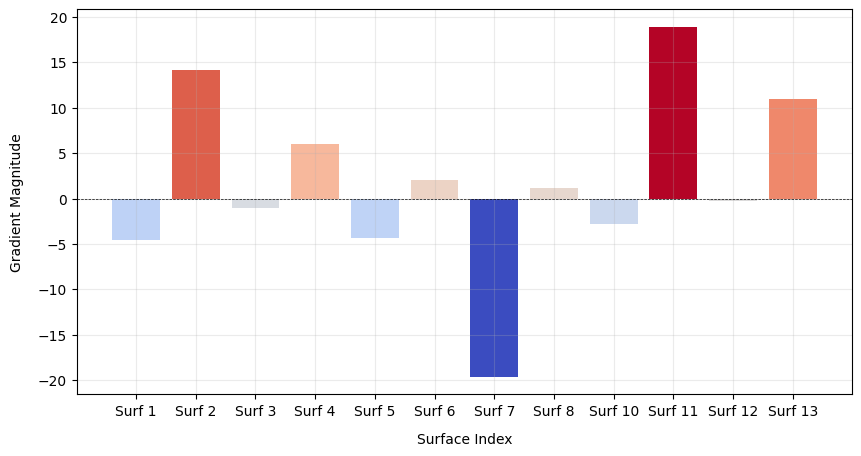

In [9]:
# plot the gradients
plt.figure(figsize=(10, 5))

gradients = np.array(gradients)
normalized_heights = (gradients - gradients.min()) / (gradients.max() - gradients.min())
cmap = plt.get_cmap("coolwarm")
colors = cmap(normalized_heights)

plt.bar(
    range(len(gradients)),
    gradients,
    color=colors,
    tick_label=[f"Surf {i}" for i in surf_idx],
)
plt.xlabel("Surface Index", labelpad=10)
plt.ylabel("Gradient Magnitude", labelpad=10)
plt.grid(alpha=0.25)
plt.axhline(0, color="black", lw=0.5, ls="--")
plt.show()